In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
# Uploading db file and syncing database
drive.mount('/content/gdrive')
conn = sqlite3.connect('/content/gdrive/MyDrive/CS_4641/database.db')

Mounted at /content/gdrive


In [ ]:
team_data = pd.read_sql("SELECT * FROM Team;", conn) # team_specific data with name and api id
team_attribute_data = pd.read_sql("SELECT * FROM Team_Attributes", conn) # team_attribute data 
match_data = pd.read_sql("SELECT * FROM Match;", conn) # all matches from 2008-2016

# Select only scorelines and teams playing in match
match_data = match_data[['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]

# Drop all the play type classifier variables in attributes
team_attribute_data.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayPassingClass', 'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass', 'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass'], axis=1, inplace=True)
team_attribute_data.replace({'Little':0, 'Normal':1, 'Lots':2}, inplace=True)
team_attribute_data


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1,434,9930,2010-02-22 00:00:00,60,0,50,60,65,55,50,55,45
1,2,434,9930,2014-09-19 00:00:00,52,1,56,54,63,64,47,44,54
2,3,434,9930,2015-09-10 00:00:00,47,1,54,54,63,64,47,44,54
3,4,77,8485,2010-02-22 00:00:00,70,0,70,70,70,70,60,70,70
4,5,77,8485,2011-02-22 00:00:00,47,0,52,53,48,52,47,47,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1454,15005,10000,2011-02-22 00:00:00,52,0,52,52,48,53,46,48,53
1454,1455,15005,10000,2012-02-22 00:00:00,54,0,51,47,52,50,44,55,53
1455,1456,15005,10000,2013-09-20 00:00:00,54,0,51,47,52,32,44,58,37
1456,1457,15005,10000,2014-09-19 00:00:00,54,1,51,47,52,32,44,58,37


In [ ]:
# params: match - row of the match df
# This function takes in a match and returns all the team_specific attributes for the home and the away team as a dataframe
def get_team_stats_for_match(match):
  home_team_id = match.home_team_api_id
  away_team_id = match.away_team_api_id
  # Retrieve the home and away team attributes. 
  home_team_data = get_team_attributes(home_team_id).add_prefix('home_')
  away_team_data = get_team_attributes(away_team_id).add_prefix('away_')
  # Combine both team stats
  combined = pd.concat([home_team_data, away_team_data])
  return combined

# params: team_api_id - unique team identifier.
# Function gets the team stats for a specific team, and then averages across multiple instances.
def get_team_attributes(team_api_id):
  team_data = team_attribute_data.loc[team_attribute_data['team_api_id'] == team_api_id]
  team_data.drop(['id', 'date', 'team_fifa_api_id', 'team_api_id'], axis=1, inplace=True)

  dribble_class = team_data['buildUpPlayDribblingClass'].mode() # pick most frequence dribblingClass assignment as chosen value instead of averaging out

  data = team_data.mean()
  data['buildUpPlayDribblingClass'] = dribble_class
  return data

In [ ]:
df = match_data 
# df = match_data.head(7)
# print(df)
# df['home_buildUpPlaySpeed'], df['home_buildUpPlayDribblingClass'], df['home_buildUpPlayPassing'],df['home_chanceCreationPassing'],df['home_chanceCreationCrossing'],df['home_chanceCreationShooting'],df['home_defencePressure'],df['home_defenceAggression'],df['home_defenceTeamWidth'],df['home_buildUpPlaySpeed'], df['away_buildUpPlayDribblingClass'], df['away_buildUpPlayPassing'],df['away_chanceCreationPassing'],df['away_chanceCreationCrossing'],df['away_chanceCreationShooting'],df['away_defencePressure'],df['away_defenceAggression'],df['away_defenceTeamWidth']=get_team_stats_for_match(df['match_api_id'])
new_cols = df.apply(lambda row: get_team_stats_for_match(row), axis=1)
df = pd.concat([df, new_cols], axis=1)
df = df.dropna()
match_data_with_team_attributes = df
match_data_with_team_attributes


,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,...,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,492473,9987,9993,1,1,56.333333,0.0,44.333333,55.666667,52.333333,...,59.833333,46.000000,0.0,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000
1,492474,10000,9994,0,0,55.500000,0.0,52.666667,50.000000,49.333333,...,47.833333,64.000000,0.0,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000
2,492475,9984,8635,0,3,53.666667,0.0,44.166667,59.000000,60.333333,...,64.666667,51.333333,0.0,45.166667,63.500000,55.000000,51.333333,59.666667,47.666667,63.833333
3,492476,9991,9998,5,0,54.166667,0.0,46.333333,44.500000,64.666667,...,45.666667,51.666667,0.0,51.666667,55.000000,60.666667,46.000000,46.000000,45.000000,47.000000
5,492478,8203,8342,1,1,56.666667,0.0,47.333333,47.500000,49.833333,...,52.000000,49.166667,0.0,46.500000,48.833333,55.833333,47.666667,53.666667,53.833333,54.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,1992089,10243,10191,3,3,56.833333,0.0,50.000000,48.000000,55.166667,...,55.666667,56.600000,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000
25974,1992091,10190,10191,1,0,47.600000,0.0,51.800000,39.800000,45.200000,...,50.800000,56.600000,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000
25975,1992092,9824,10199,1,2,53.000000,0.0,56.000000,38.000000,53.000000,...,58.000000,51.833333,0.0,52.500000,53.000000,48.333333,61.000000,48.000000,48.333333,50.333333
25976,1992093,9956,10179,2,0,49.500000,0.0,53.166667,53.000000,58.666667,...,51.666667,54.333333,0.0,44.000000,60.833333,52.666667,54.333333,42.666667,43.833333,50.000000


In [ ]:
# Classification test
# team1 = team_attribute_data.loc[team_attribute_data['team_api_id'] == 9930]
# team1

In [ ]:
# team1plus = match_data_with_team_attributes.loc[match_data_with_team_attributes['home_team_api_id'] == 9930]
# team1plus

In [ ]:
def get_winloss_num(dif):
  if dif < 0:
    return 0
  elif dif > 0:
    return 2
  else:
    return 1

df = match_data_with_team_attributes
df['winloss'] = df['home_team_goal'] - df['away_team_goal']
df['winloss'] = df['winloss'].apply(get_winloss_num)
df.drop(['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal'], axis=1, inplace=True)
match_data_with_team_attributes = df

# Data preprocessing stops here

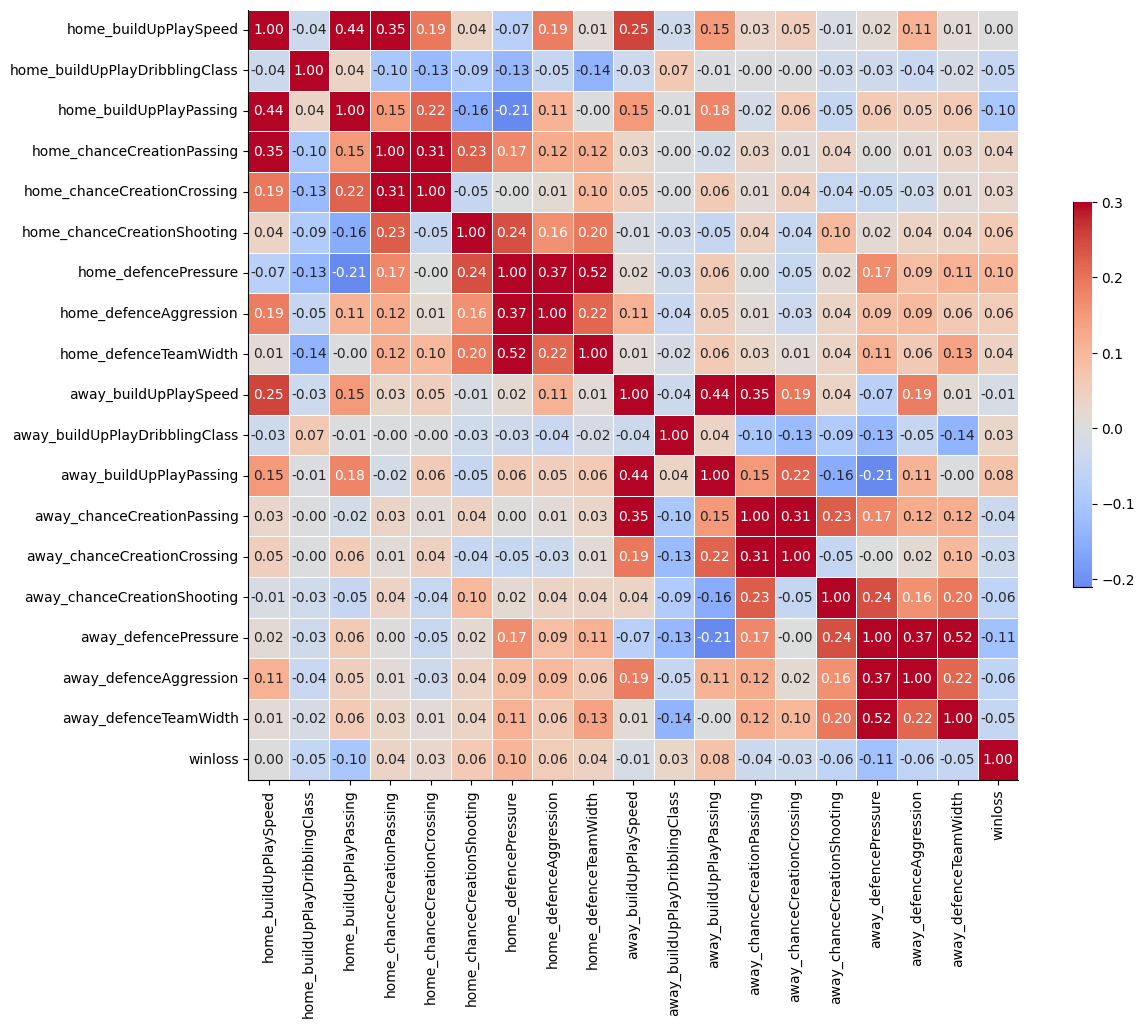

In [ ]:
corr = match_data_with_team_attributes.corr()

g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')

sns.despine()
g.figure.set_size_inches(14,10)
    
plt.show()

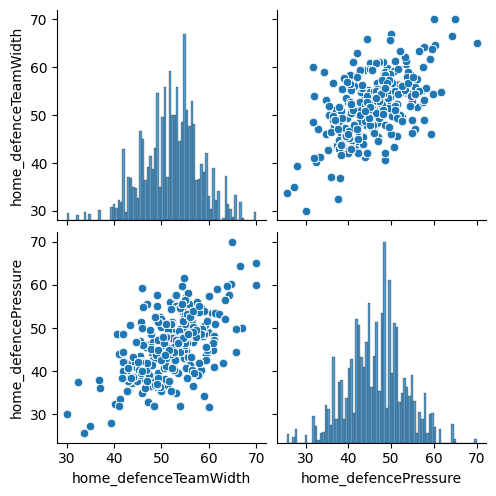

In [ ]:
g = sns.pairplot(match_data_with_team_attributes[['home_defenceTeamWidth','home_defencePressure']])


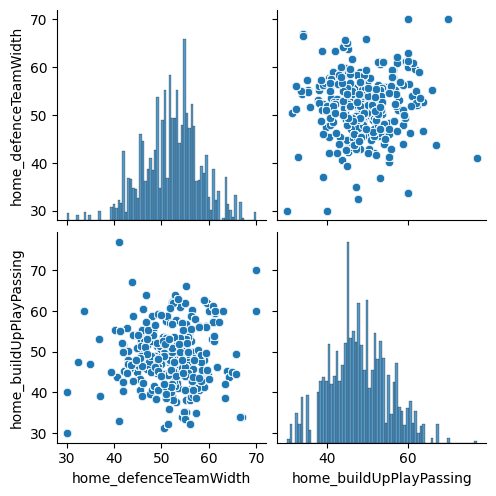

In [ ]:
# g = sns.pairplot(match_data_with_team_attributes[['home_buildUpPlaySpeed','home_buildUpPlayPassing','home_chanceCreationPassing']])
g = sns.pairplot(match_data_with_team_attributes[['home_defenceTeamWidth','home_buildUpPlayPassing']])


                                     PC0       PC1       PC2       PC3  \
home_buildUpPlaySpeed           0.242275 -0.373789 -0.087682  0.315379   
home_buildUpPlayDribblingClass -0.150346 -0.047740  0.164300  0.012080   
home_buildUpPlayPassing         0.143170 -0.394494  0.051969  0.375391   
home_chanceCreationPassing      0.240818 -0.124196 -0.285015  0.293935   
home_chanceCreationCrossing     0.129297 -0.234081 -0.180876  0.273450   
home_chanceCreationShooting     0.187328  0.181668 -0.256205 -0.082267   
home_defencePressure            0.314288  0.267088 -0.347947 -0.214914   
home_defenceAggression          0.295826  0.032835 -0.245575 -0.010786   
home_defenceTeamWidth           0.309295  0.164383 -0.296315 -0.120722   
away_buildUpPlaySpeed           0.251489 -0.354119  0.124709 -0.319725   
away_buildUpPlayDribblingClass -0.147113 -0.057865 -0.162638 -0.000244   
away_buildUpPlayPassing         0.149795 -0.385548 -0.015092 -0.385660   
away_chanceCreationPassing      0.2537

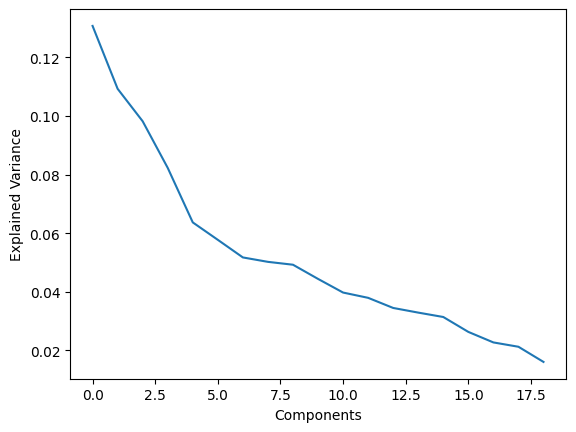

TypeError: ignored

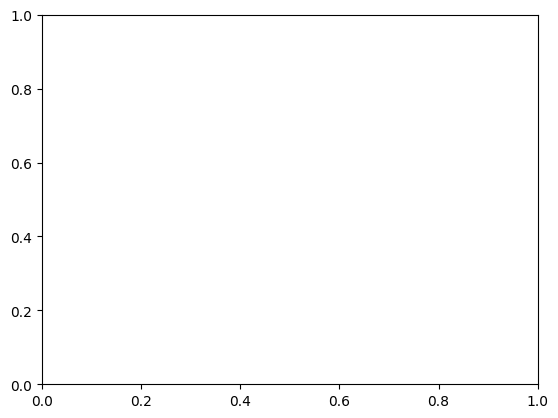

In [ ]:
# Machine Learning Code

train, test = train_test_split(df, test_size=0.2) 

# normalize training data. 
df = train
df_normalized=(df - df.mean()) / df.std() # Redundant 
df_normalized

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()


In [ ]:
df = match_data_with_team_attributes
x_train, x_test, y_train, y_test = train_test_split(df.drop('winloss', axis=1), df['winloss'], test_size=0.2, random_state=0)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr') # or 'multinomial')
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))

# # specify hyperparameter grid
# param_grid = {
#     'penalty': ['l1', 'l2'], 
#     'C': [0.1, 1, 10, 100], 
#     'solver': ['liblinear', 'saga']
# }
# # instantiate logistic regression model
# logreg = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr') # or 'multinomial')
# # instantiate grid search
# grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1')

# # fit grid search to data
# grid_search.fit(x_train, y_train)
# y_pred = logreg.predict(x_test)
# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Precision:', precision_score(y_test, y_pred, average='macro'))
# print('Recall:', recall_score(y_test, y_pred, average='macro'))
# print('F1-score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.4828140703517588
Precision: 0.30788535262253797
Recall: 0.3822038982940909
F1-score: 0.31893260139375185


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


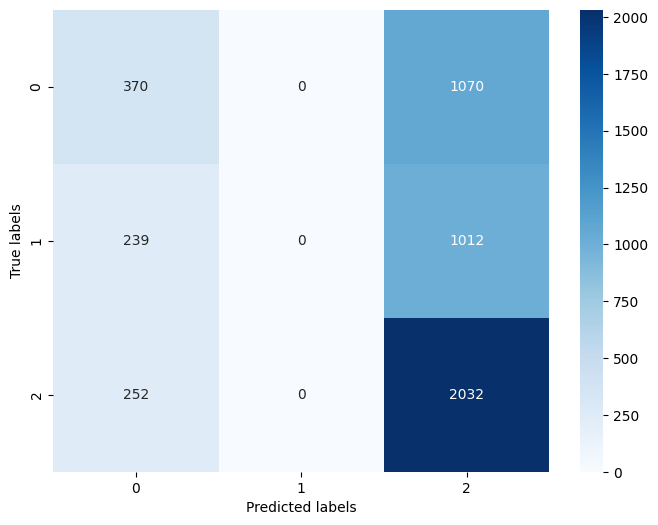

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()